<a href="https://colab.research.google.com/github/aparnashenoy/ml/blob/master/rac_2022_oversample_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
path = '/gdrive/My Drive/'

In [4]:
df = pd.read_csv(path +'data_updated_sample.csv')

In [5]:
df.head()

,Unnamed: 0,Gender,custom_hr,custom_temp,custom_age,custom_o2sat,custom_bp,custom_resp,Unit1,Unit2,ICULOS,SepsisLabel
0,0,0,0,1,1,2,3,0,0.0,1.0,17,0
1,1,0,1,0,1,2,3,0,0.0,1.0,10,0
2,2,0,2,0,0,2,3,0,1.0,0.0,11,0
3,3,1,2,1,0,1,3,1,1.0,0.0,13,0
4,4,1,0,1,0,2,3,0,1.0,0.0,2,0


In [6]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [7]:
df.head()

,Gender,custom_hr,custom_temp,custom_age,custom_o2sat,custom_bp,custom_resp,Unit1,Unit2,ICULOS,SepsisLabel
0,0,0,1,1,2,3,0,0.0,1.0,17,0
1,0,1,0,1,2,3,0,0.0,1.0,10,0
2,0,2,0,0,2,3,0,1.0,0.0,11,0
3,1,2,1,0,1,3,1,1.0,0.0,13,0
4,1,0,1,0,2,3,0,1.0,0.0,2,0


In [8]:
df.isna().sum()

Gender          0
custom_hr       0
custom_temp     0
custom_age      0
custom_o2sat    0
custom_bp       0
custom_resp     0
Unit1           0
Unit2           0
ICULOS          0
SepsisLabel     0
dtype: int64

In [9]:
df.shape

(36302, 11)

In [10]:
df.SepsisLabel.value_counts()

0    33655
1     2647
Name: SepsisLabel, dtype: int64

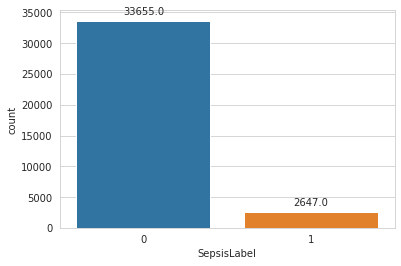

In [11]:
sns.set_style('whitegrid')
ax = sns.countplot(x='SepsisLabel', data=df)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

In [12]:
Xcol = df.drop(columns = ["SepsisLabel"])
ycol = df["SepsisLabel"]

In [13]:
X=np.array(Xcol)
y=np.array(ycol)
X.shape, y.shape

((36302, 10), (36302,))

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((27226, 10), (9076, 10), (27226,), (9076,))

In [15]:
import imblearn

In [16]:
from imblearn import under_sampling, over_sampling

In [17]:
#Performing random undersampling on the training dataset
ros = imblearn.over_sampling.RandomOverSampler(sampling_strategy=1.0)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
X_ros.shape, y_ros.shape

((50530, 10), (50530,))

In [18]:
#Checking the class distribution of the target
pd.crosstab(y_ros, columns='count')/len(y_ros)*100

col_0,count
row_0,
0,50.0
1,50.0


In [19]:
pd.crosstab(y_train, columns='count')

col_0,count
row_0,
0,25265
1,1961


In [20]:
pd.crosstab(y_ros, columns = 'count')

col_0,count
row_0,
0,25265
1,25265


In [21]:
#Performing random undersampling on the training dataset
ros = imblearn.over_sampling.RandomOverSampler(sampling_strategy=1.0)
X_ros_test, y_ros_test = ros.fit_resample(X_test, y_test)

In [22]:
#Checking the class distribution of the target
pd.crosstab(y_ros_test, columns='count')/len(y_ros_test)*100

col_0,count
row_0,
0,50.0
1,50.0


In [23]:
pd.crosstab(y_test, columns='count')

col_0,count
row_0,
0,8390
1,686


In [24]:
pd.crosstab(y_ros_test, columns='count')

col_0,count
row_0,
0,8390
1,8390


**Logistic Regression**

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [26]:
fold = StratifiedKFold(n_splits=5, random_state=1, shuffle = True)
fold.get_n_splits(X_ros, y_ros)

5

In [27]:
val =list(np.arange(0.001,11,0.1))

In [28]:
parameters = {'solver':('newton-cg', 'liblinear'), 'C':[0.001]}

model = LogisticRegression(penalty='l2', n_jobs = -2, max_iter=1000)
log_reg = GridSearchCV(model, parameters, n_jobs= -2, cv=fold)

log_reg.fit(X_ros, y_ros)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=LogisticRegression(max_iter=1000, n_jobs=-2), n_jobs=-2,
             param_grid={'C': [0.001], 'solver': ('newton-cg', 'liblinear')})

In [29]:
print(log_reg.best_params_)

{'C': 0.001, 'solver': 'liblinear'}


In [30]:
yt_pred_log_reg = log_reg.predict(X_ros_test)
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_ros_test, yt_pred_log_reg ))

ac= accuracy_score(y_ros_test, yt_pred_log_reg)
print('test_accuracy = {} % '.format(ac * 100))

              precision    recall  f1-score   support

           0       0.71      0.83      0.77      8390
           1       0.80      0.66      0.72      8390

    accuracy                           0.75     16780
   macro avg       0.75      0.75      0.75     16780
weighted avg       0.75      0.75      0.75     16780

test_accuracy = 74.70202622169249 % 


In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
cf_matrix = confusion_matrix(y_ros_test, yt_pred_log_reg)
print(cf_matrix)

[[6995 1395]
 [2850 5540]]


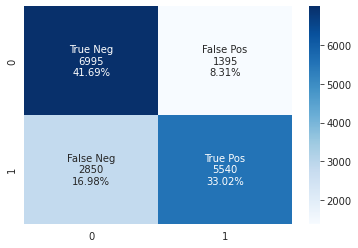

In [33]:
import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [34]:
from sklearn.metrics import roc_auc_score
lr_probs = log_reg.predict_proba(X_ros_test)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_ros_test, lr_probs)

print('LR - ROC AUC= {} %'.format(round(lr_auc, 3)*100))

LR - ROC AUC= 83.39999999999999 %


**Random Forest Classifier**

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_ros, y_ros)

RandomForestClassifier(n_estimators=500)

In [36]:
y_pred_rf= rf.predict(X_ros_test)

from sklearn.metrics import classification_report
print(classification_report(y_ros_test, y_pred_rf))
ac= accuracy_score(y_ros_test, y_pred_rf)
print('test_accuracy = {} % '.format(ac * 100))

              precision    recall  f1-score   support

           0       0.64      0.90      0.75      8390
           1       0.83      0.49      0.62      8390

    accuracy                           0.70     16780
   macro avg       0.74      0.70      0.68     16780
weighted avg       0.74      0.70      0.68     16780

test_accuracy = 69.53516090584029 % 


In [37]:
cf_matrix = confusion_matrix(y_ros_test, y_pred_rf)
print(cf_matrix)

[[7559  831]
 [4281 4109]]


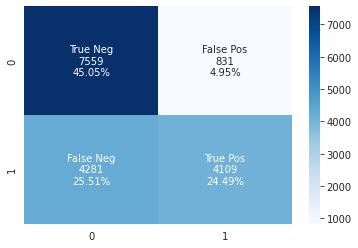

In [38]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [39]:
from sklearn.metrics import roc_auc_score
rf_probs = rf.predict_proba(X_ros_test)
rf_probs = rf_probs[:, 1]
rf_auc = roc_auc_score(y_ros_test, rf_probs)

print('RF - ROC AUC= {} %'.format(round(rf_auc, 3)*100))

RF - ROC AUC= 78.2 %


In [40]:
from sklearn.metrics import roc_curve

In [41]:
rf_fpr, rf_tpr, rf_thres = roc_curve(y_ros_test, rf_probs)

In [42]:
from sklearn.preprocessing import OneHotEncoder

# It is important to train the ensemble of trees on a different subset of the training 
#data than the linear regression model to avoid overfitting, in particular 
#if the total number of leaves is similar to the number of training samples
x_ros, X_ros_lr, yros, y_ros_lr = train_test_split(X_ros, y_ros, test_size=0.60, shuffle = True)

rf = RandomForestClassifier(n_estimators=1000)
#train Random forest on a set of samples
rf.fit(x_ros, yros)

#one hot encoder of the leaves
rf_enc = OneHotEncoder()

#for these leaves of RF, fit the one hot encoder
rf_enc.fit(rf.apply(X_ros))

rf_enc

OneHotEncoder()

In [43]:
f = rf_enc.transform(rf.apply(X_ros_lr))
f.shape

(30318, 2108213)

In [44]:
fold = StratifiedKFold(n_splits=5, random_state=1, shuffle = True)
fold.get_n_splits(X_ros_lr, y_ros_lr)

parameters = {'solver':('liblinear', 'sag'), 'C':[0.001]}

model = LogisticRegression(penalty='l2', n_jobs = -2, max_iter=1000)
rf_lr = GridSearchCV(model, parameters, n_jobs= -2, cv=fold)


rf_lr.fit(rf_enc.transform(rf.apply(X_ros_lr)), y_ros_lr)

print(rf_lr.best_params_)

{'C': 0.001, 'solver': 'sag'}


In [45]:
yprobs_rf_lr = rf_lr.predict_proba(rf_enc.transform(rf.apply(X_ros_test)))
yprobs_rf_lr= yprobs_rf_lr[:, 1]

In [46]:
rf_lr_auc = roc_auc_score(y_ros_test, yprobs_rf_lr)
print('Logistic regression + Random Forest: ROC AUC= {} %'.format(round(rf_lr_auc, 3)*100))

Logistic regression + Random Forest: ROC AUC= 82.39999999999999 %


In [47]:
y_pred_rf_lr = rf_lr.predict(rf_enc.transform(rf.apply(X_ros_test)))

In [48]:
print(classification_report(y_ros_test, y_pred_rf_lr))
ac= accuracy_score(y_ros_test, y_pred_rf_lr)
print('test_accuracy = {} % '.format(ac * 100))

              precision    recall  f1-score   support

           0       0.66      0.88      0.75      8390
           1       0.82      0.55      0.66      8390

    accuracy                           0.71     16780
   macro avg       0.74      0.71      0.70     16780
weighted avg       0.74      0.71      0.70     16780

test_accuracy = 71.2336114421931 % 


In [49]:
cf_matrix = confusion_matrix(y_ros_test, y_pred_rf_lr)
print(cf_matrix)

[[7363 1027]
 [3800 4590]]


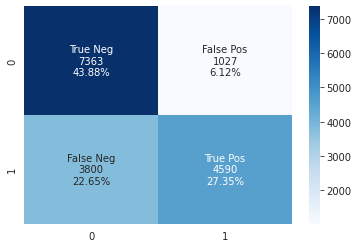

In [50]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [51]:
fpr_rf_lr, tpr_rf_lr, thres_rf_lr = roc_curve(y_ros_test, yprobs_rf_lr)

In [52]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_ros, y_ros)

AdaBoostClassifier(n_estimators=100, random_state=0)

In [53]:
y_pred_clf= clf.predict(X_ros_test)

from sklearn.metrics import classification_report
print(classification_report(y_ros_test, y_pred_clf))
ac= accuracy_score(y_ros_test, y_pred_clf)
print('test_accuracy = {} % '.format(ac * 100))

              precision    recall  f1-score   support

           0       0.74      0.83      0.78      8390
           1       0.81      0.70      0.75      8390

    accuracy                           0.77     16780
   macro avg       0.77      0.77      0.77     16780
weighted avg       0.77      0.77      0.77     16780

test_accuracy = 76.59713945172825 % 


In [54]:
cf_matrix = confusion_matrix(y_ros_test, y_pred_clf)
print(cf_matrix)

[[6964 1426]
 [2501 5889]]


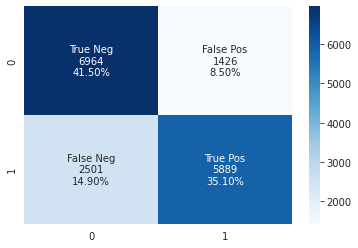

In [55]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [56]:
clf_probs = clf.predict_proba(X_ros_test)
clf_probs = clf_probs[:, 1]
clf_auc = roc_auc_score(y_ros_test, clf_probs)

print('ADABOOST - ROC AUC= {} %'.format(round(clf_auc, 3)*100))

ADABOOST - ROC AUC= 86.5 %


In [57]:
clf_fpr, clf_tpr, clf_thres = roc_curve(y_ros_test, clf_probs)

In [58]:
logreg_fpr, logreg_tpr, logreg_thres= roc_curve(y_ros_test, lr_probs)

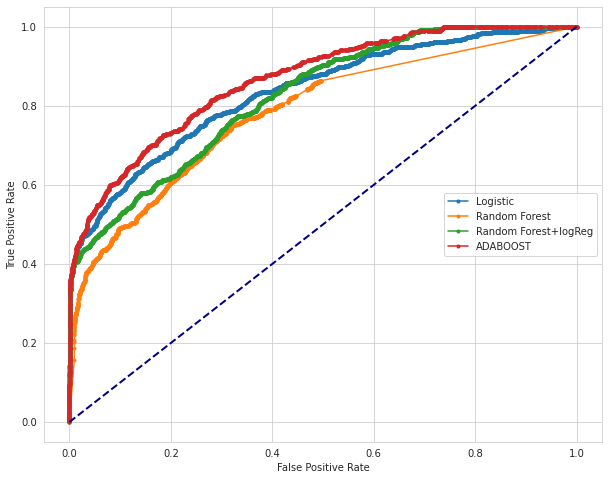

In [59]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(logreg_fpr, logreg_tpr, marker='.', label='Logistic')
ax.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
ax.plot(fpr_rf_lr, tpr_rf_lr, marker='.', label='Random Forest+logReg')
ax.plot(clf_fpr, clf_tpr, marker='.', label='ADABOOST')
lw = 2
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend(loc=5)
# show the plot
plt.show()

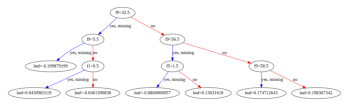

<Figure size 3600x3960 with 0 Axes>

In [60]:
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt
model = XGBClassifier()

# Train
model.fit(X_ros, y_ros)

plot_tree(model)
plt.figure(figsize = (50,55))
plt.show()

In [61]:
print(model.get_xgb_params)

<bound method XGBModel.get_xgb_params of XGBClassifier()>


In [62]:
y_pred_xgb= model.predict(X_ros_test)

from sklearn.metrics import classification_report
print(classification_report(y_ros_test, y_pred_xgb))
ac= accuracy_score(y_ros_test, y_pred_xgb)
print('test_accuracy = {} % '.format(ac * 100))

              precision    recall  f1-score   support

           0       0.72      0.85      0.78      8390
           1       0.81      0.68      0.74      8390

    accuracy                           0.76     16780
   macro avg       0.77      0.76      0.76     16780
weighted avg       0.77      0.76      0.76     16780

test_accuracy = 76.20977353992848 % 


In [63]:
cf_matrix = confusion_matrix(y_ros_test, y_pred_xgb)
print(cf_matrix)

[[7096 1294]
 [2698 5692]]


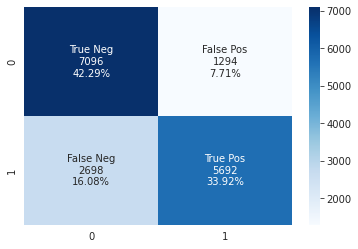

In [64]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [65]:
model_probs = model.predict_proba(X_ros_test)
model_probs = model_probs[:, 1]
model_auc = roc_auc_score(y_ros_test, model_probs)

print('XGBoost - ROC AUC= {} %'.format(round(model_auc, 3)*100))

XGBoost - ROC AUC= 86.7 %


In [66]:
model_fpr, model_tpr, model_thres = roc_curve(y_ros_test, model_probs)

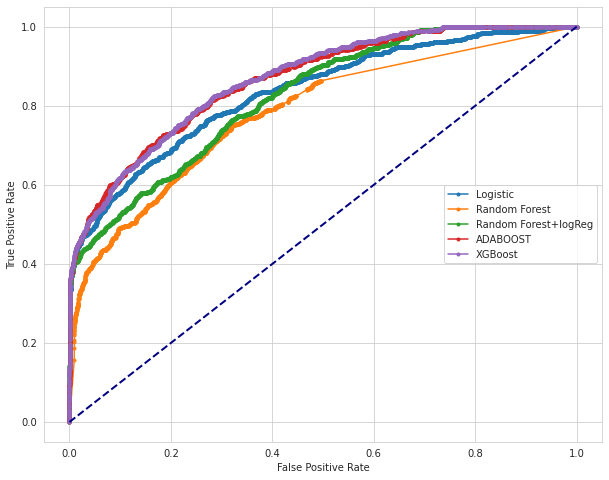

In [67]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(logreg_fpr, logreg_tpr, marker='.', label='Logistic')
ax.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
ax.plot(fpr_rf_lr, tpr_rf_lr, marker='.', label='Random Forest+logReg')
ax.plot(clf_fpr, clf_tpr, marker='.', label='ADABOOST')
ax.plot(model_fpr, model_tpr, marker = '.', label='XGBoost')
lw = 2
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend(loc=5)
# show the plot
plt.show()